In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import tensorflow.keras
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix

2023-03-06 01:30:55.368122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 01:30:55.368163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
allData = pd.read_csv('../feature_data/features.csv')
allData.replace([np.inf, -np.inf], np.nan, inplace=True)
allData = allData.dropna()
X = allData.drop(["label"],axis=1)
X = X.drop(["radius"],axis=1)
cols = X.keys()

#normalize data
#X = preprocessing.normalize(X, norm='max')

#labels
y = allData["label"]

#features
X = pd.DataFrame(X, columns = cols)

In [3]:
X.describe()

,num_points,std,avg_median_dev,width,linearity,circularity,boundary_length,boundary_regularity,mean_curvature,ang_diff,iav,std_iav,distance,dist_num_points,occluded_right,occluded_left
count,9806.000000,9806.000000,9806.000000,9806.000000,9.806000e+03,9.806000e+03,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000
mean,18.573424,0.155794,0.132193,0.478954,1.719161e+05,2.162968e-01,0.573900,0.017148,19.671369,2.252501,2.633213,1.539466,2.931023,0.428165,0.828778,0.794106
std,28.678977,0.248922,0.217844,0.849119,1.702283e+07,3.459030e+00,0.990118,0.011786,18.917133,0.634995,0.720279,0.534465,1.861660,0.512021,0.376722,0.404374
min,3.000000,0.008728,0.005819,0.014005,7.595700e-05,7.466420e-16,0.017456,0.003010,0.002851,0.268210,0.418680,0.272501,0.397633,0.001606,0.000000,0.000000
25%,5.000000,0.038899,0.031814,0.102608,7.322395e-03,1.811335e-04,0.131358,0.008254,5.872723,1.890190,2.218225,1.172418,1.486060,0.093868,1.000000,1.000000
50%,10.000000,0.058458,0.046321,0.147167,2.599895e-02,9.166170e-04,0.202548,0.013237,12.930850,2.401155,2.780340,1.560275,2.353025,0.236878,1.000000,1.000000
75%,18.000000,0.152486,0.130204,0.450897,1.049683e+00,7.258853e-03,0.544972,0.024069,27.531075,2.754230,3.134130,1.903998,3.907210,0.559758,1.000000,1.000000
max,356.000000,2.855230,2.395890,10.926500,1.685690e+09,3.149590e+02,11.157400,0.073894,113.683000,3.127760,4.565440,3.163050,7.457900,2.485970,1.000000,1.000000


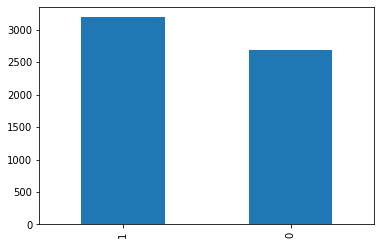

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5)
y_train.value_counts().plot.bar()


#oversample the minority
y_train.value_counts().plot.bar()

ros = RandomOverSampler(sampling_strategy="minority", random_state=5)
#X_train, y_train = ros.fit_resample(X_train, y_train)

#y_train.value_counts().plot.bar()
#y_test.value_counts().plot.bar()

In [5]:
def CNN_Model(units = 32, dropout=0.2, optimizer = 'adam'):
    model = models.Sequential()
    model.add(tensorflow.keras.Input(shape=(16,)))
    model.add(tf.keras.layers.BatchNormalization())

    #model.add(layers.Dropout(dropout))
    model.add(layers.Dense(units = units, activation='leaky_relu',))

    model.add(layers.Dense(units = units/2, activation='leaky_relu',))

    model.add(layers.Dense(units = units/4, activation='leaky_relu'))

    
    model.add(layers.Dense(units = units/2, activation='leaky_relu',))

    model.add(layers.Dense(units = units, activation='leaky_relu'))
    #model.add(layers.Dropout(dropout))


    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model
    

In [6]:
ms = []
hs = []
for f in [32,64,96,128]:
    #for d in [0.15,0.2,0.25,0.3]:
    #    if (f == 32 and d == 0.2) or (f==64 and d==0.15) or (f==96 and d!=0.2):
    model = CNN_Model(units=f)
    model.summary()
    ms.append(model)
    history = model.fit(X_train, y_train, epochs=150, 
                    validation_data=(X_val, y_val))
    hs.append(history)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                        

2023-03-06 01:31:09.706833: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-06 01:31:09.706913: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pedrod33): /proc/driver/nvidia/version does not exist
2023-03-06 01:31:09.708755: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/150
184/184 [==============================] - 2s 4ms/step - loss: 0.2690 - accuracy: 0.8781 - val_loss: 0.3021 - val_accuracy: 0.8807
Epoch 2/150
184/184 [==============================] - 1s 3ms/step - loss: 0.2304 - accuracy: 0.8933 - val_loss: 0.2135 - val_accuracy: 0.9001
Epoch 3/150
184/184 [==============================] - 1s 3ms/step - loss: 0.2131 - accuracy: 0.9048 - val_loss: 0.2064 - val_accuracy: 0.9041
Epoch 4/150
184/184 [==============================] - 1s 3ms/step - loss: 0.2197 - accuracy: 0.8995 - val_loss: 0.2054 - val_accuracy: 0.9057
Epoch 5/150
184/184 [==============================] - 1s 3ms/step - loss: 0.2177 - accuracy: 0.9045 - val_loss: 0.2017 - val_accuracy: 0.9062
Epoch 6/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1995 - accuracy: 0.9119 - val_loss: 0.2388 - val_accuracy: 0.9021
Epoch 7/150
184/184 [==============================] - 1s 3ms/step - loss: 0.2020 - accuracy: 0.9119 - val_loss: 0.2225 - val_accuracy: 0.9169

Epoch 58/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1631 - accuracy: 0.9363 - val_loss: 0.1624 - val_accuracy: 0.9332
Epoch 59/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1571 - accuracy: 0.9368 - val_loss: 0.1671 - val_accuracy: 0.9291
Epoch 60/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1611 - accuracy: 0.9363 - val_loss: 0.1695 - val_accuracy: 0.9332
Epoch 61/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1565 - accuracy: 0.9339 - val_loss: 0.1736 - val_accuracy: 0.9352
Epoch 62/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1597 - accuracy: 0.9308 - val_loss: 0.1680 - val_accuracy: 0.9322
Epoch 63/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1491 - accuracy: 0.9369 - val_loss: 0.1796 - val_accuracy: 0.9204
Epoch 64/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1651 - accuracy: 0.9337 - val_loss: 0.1756 - val_accuracy:

Epoch 115/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1489 - accuracy: 0.9417 - val_loss: 0.1513 - val_accuracy: 0.9434
Epoch 116/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1472 - accuracy: 0.9442 - val_loss: 0.1482 - val_accuracy: 0.9414
Epoch 117/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1384 - accuracy: 0.9458 - val_loss: 0.1581 - val_accuracy: 0.9337
Epoch 118/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1486 - accuracy: 0.9391 - val_loss: 0.1630 - val_accuracy: 0.9383
Epoch 119/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.9429 - val_loss: 0.1712 - val_accuracy: 0.9368
Epoch 120/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1385 - accuracy: 0.9476 - val_loss: 0.1708 - val_accuracy: 0.9388
Epoch 121/150
184/184 [==============================] - 0s 3ms/step - loss: 0.1516 - accuracy: 0.9410 - val_loss: 0.1621 - val_ac

Epoch 12/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1997 - accuracy: 0.9133 - val_loss: 0.1903 - val_accuracy: 0.9077
Epoch 13/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1856 - accuracy: 0.9184 - val_loss: 0.2107 - val_accuracy: 0.9204
Epoch 14/150
184/184 [==============================] - 1s 3ms/step - loss: 0.2025 - accuracy: 0.9165 - val_loss: 0.1892 - val_accuracy: 0.9225
Epoch 15/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1931 - accuracy: 0.9164 - val_loss: 0.1921 - val_accuracy: 0.9189
Epoch 16/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1902 - accuracy: 0.9182 - val_loss: 0.1958 - val_accuracy: 0.9250
Epoch 17/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1938 - accuracy: 0.9186 - val_loss: 0.1892 - val_accuracy: 0.9240
Epoch 18/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1863 - accuracy: 0.9230 - val_loss: 0.1839 - val_accuracy:

Epoch 69/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1606 - accuracy: 0.9340 - val_loss: 0.1761 - val_accuracy: 0.9414
Epoch 70/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1565 - accuracy: 0.9388 - val_loss: 0.1618 - val_accuracy: 0.9388
Epoch 71/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1507 - accuracy: 0.9407 - val_loss: 0.1608 - val_accuracy: 0.9327
Epoch 72/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1844 - accuracy: 0.9288 - val_loss: 0.1870 - val_accuracy: 0.9296
Epoch 73/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1669 - accuracy: 0.9351 - val_loss: 0.1843 - val_accuracy: 0.9271
Epoch 74/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1564 - accuracy: 0.9339 - val_loss: 0.1651 - val_accuracy: 0.9276
Epoch 75/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1563 - accuracy: 0.9368 - val_loss: 0.1631 - val_accuracy:

Epoch 126/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1554 - accuracy: 0.9391 - val_loss: 0.1588 - val_accuracy: 0.9403
Epoch 127/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1595 - accuracy: 0.9388 - val_loss: 0.1734 - val_accuracy: 0.9388
Epoch 128/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1481 - accuracy: 0.9417 - val_loss: 0.1810 - val_accuracy: 0.9266
Epoch 129/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1609 - accuracy: 0.9385 - val_loss: 0.1586 - val_accuracy: 0.9393
Epoch 130/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.9351 - val_loss: 0.1652 - val_accuracy: 0.9332
Epoch 131/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1557 - accuracy: 0.9371 - val_loss: 0.1648 - val_accuracy: 0.9388
Epoch 132/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1483 - accuracy: 0.9422 - val_loss: 0.1665 - val_ac

Epoch 23/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1822 - accuracy: 0.9208 - val_loss: 0.2021 - val_accuracy: 0.9001
Epoch 24/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1796 - accuracy: 0.9259 - val_loss: 0.2114 - val_accuracy: 0.9189
Epoch 25/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1741 - accuracy: 0.9296 - val_loss: 0.1910 - val_accuracy: 0.9194
Epoch 26/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1844 - accuracy: 0.9225 - val_loss: 0.1888 - val_accuracy: 0.9108
Epoch 27/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1733 - accuracy: 0.9279 - val_loss: 0.1896 - val_accuracy: 0.9220
Epoch 28/150
184/184 [==============================] - 1s 4ms/step - loss: 0.1794 - accuracy: 0.9238 - val_loss: 0.1884 - val_accuracy: 0.9255
Epoch 29/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1819 - accuracy: 0.9267 - val_loss: 0.1780 - val_accuracy:

Epoch 80/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1556 - accuracy: 0.9363 - val_loss: 0.1672 - val_accuracy: 0.9276
Epoch 81/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1581 - accuracy: 0.9342 - val_loss: 0.1661 - val_accuracy: 0.9276
Epoch 82/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1940 - accuracy: 0.9298 - val_loss: 0.2602 - val_accuracy: 0.9322
Epoch 83/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1938 - accuracy: 0.9240 - val_loss: 0.1883 - val_accuracy: 0.9261
Epoch 84/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.9351 - val_loss: 0.1562 - val_accuracy: 0.9327
Epoch 85/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1536 - accuracy: 0.9376 - val_loss: 0.1603 - val_accuracy: 0.9296
Epoch 86/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1588 - accuracy: 0.9383 - val_loss: 0.1705 - val_accuracy:

184/184 [==============================] - 1s 3ms/step - loss: 0.1529 - accuracy: 0.9363 - val_loss: 0.1679 - val_accuracy: 0.9276
Epoch 137/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.9361 - val_loss: 0.2590 - val_accuracy: 0.9271
Epoch 138/150
184/184 [==============================] - 1s 3ms/step - loss: 0.3277 - accuracy: 0.9065 - val_loss: 0.1855 - val_accuracy: 0.9245
Epoch 139/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1800 - accuracy: 0.9271 - val_loss: 0.1935 - val_accuracy: 0.9199
Epoch 140/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1610 - accuracy: 0.9334 - val_loss: 0.1814 - val_accuracy: 0.9306
Epoch 141/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.9342 - val_loss: 0.1972 - val_accuracy: 0.9291
Epoch 142/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1541 - accuracy: 0.9381 - val_loss: 0.1603 - val_accuracy: 0.9357

184/184 [==============================] - 1s 3ms/step - loss: 0.2237 - accuracy: 0.9018 - val_loss: 0.2037 - val_accuracy: 0.9072
Epoch 34/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1978 - accuracy: 0.9138 - val_loss: 0.1947 - val_accuracy: 0.9220
Epoch 35/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1893 - accuracy: 0.9169 - val_loss: 0.2031 - val_accuracy: 0.9092
Epoch 36/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1878 - accuracy: 0.9215 - val_loss: 0.1771 - val_accuracy: 0.9261
Epoch 37/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1869 - accuracy: 0.9136 - val_loss: 0.1885 - val_accuracy: 0.9199
Epoch 38/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1775 - accuracy: 0.9225 - val_loss: 0.1968 - val_accuracy: 0.9159
Epoch 39/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1836 - accuracy: 0.9221 - val_loss: 0.1718 - val_accuracy: 0.9245
Epoch

Epoch 90/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1827 - accuracy: 0.9216 - val_loss: 0.1950 - val_accuracy: 0.9174
Epoch 91/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1907 - accuracy: 0.9194 - val_loss: 0.1994 - val_accuracy: 0.9077
Epoch 92/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1711 - accuracy: 0.9276 - val_loss: 0.1881 - val_accuracy: 0.9276
Epoch 93/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1815 - accuracy: 0.9227 - val_loss: 0.1867 - val_accuracy: 0.9240
Epoch 94/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1780 - accuracy: 0.9250 - val_loss: 0.1752 - val_accuracy: 0.9296
Epoch 95/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1772 - accuracy: 0.9238 - val_loss: 0.1800 - val_accuracy: 0.9286
Epoch 96/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1617 - accuracy: 0.9305 - val_loss: 0.1785 - val_accuracy:

184/184 [==============================] - 1s 3ms/step - loss: 0.1926 - accuracy: 0.9191 - val_loss: 0.1767 - val_accuracy: 0.9296
Epoch 147/150
184/184 [==============================] - 1s 4ms/step - loss: 0.1674 - accuracy: 0.9296 - val_loss: 0.1740 - val_accuracy: 0.9199
Epoch 148/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1678 - accuracy: 0.9301 - val_loss: 0.1644 - val_accuracy: 0.9296
Epoch 149/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1551 - accuracy: 0.9412 - val_loss: 0.1746 - val_accuracy: 0.9271
Epoch 150/150
184/184 [==============================] - 1s 3ms/step - loss: 0.1601 - accuracy: 0.9368 - val_loss: 0.1649 - val_accuracy: 0.9357


62/62 - 0s - loss: 0.1496 - accuracy: 0.9455 - 121ms/epoch - 2ms/step
Test Loss: 0.14962726831436157
Test Accuracy: 0.9454638361930847
(1962, 1)
1962


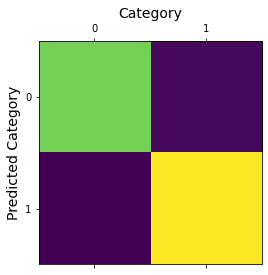

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       864
           1       0.96      0.94      0.95      1098

    accuracy                           0.95      1962
   macro avg       0.94      0.95      0.94      1962
weighted avg       0.95      0.95      0.95      1962

62/62 - 0s - loss: 0.1396 - accuracy: 0.9460 - 109ms/epoch - 2ms/step
Test Loss: 0.13955166935920715
Test Accuracy: 0.9459735155105591
(1962, 1)
1962


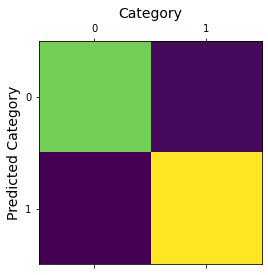

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       863
           1       0.96      0.94      0.95      1099

    accuracy                           0.95      1962
   macro avg       0.94      0.95      0.95      1962
weighted avg       0.95      0.95      0.95      1962

62/62 - 0s - loss: 0.1178 - accuracy: 0.9516 - 104ms/epoch - 2ms/step
Test Loss: 0.11783844232559204
Test Accuracy: 0.9515800476074219
(1962, 1)
1962


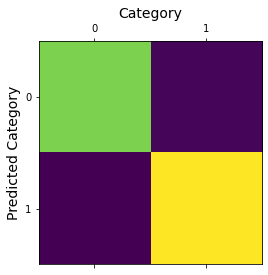

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       876
           1       0.96      0.95      0.96      1086

    accuracy                           0.95      1962
   macro avg       0.95      0.95      0.95      1962
weighted avg       0.95      0.95      0.95      1962

62/62 - 0s - loss: 0.1326 - accuracy: 0.9439 - 110ms/epoch - 2ms/step
Test Loss: 0.13256603479385376
Test Accuracy: 0.9439347386360168
(1962, 1)
1962


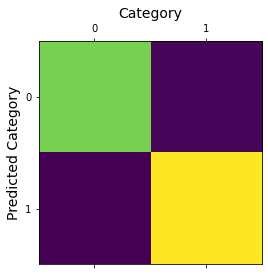

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       873
           1       0.96      0.94      0.95      1089

    accuracy                           0.94      1962
   macro avg       0.94      0.94      0.94      1962
weighted avg       0.94      0.94      0.94      1962



In [7]:
for m in ms:
    test_loss, test_acc = m.evaluate(X_test,  y_test, verbose=2)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
    y_pred = m.predict(X_test)
    print(y_pred.shape)
    a = []
    print(y_pred.size)
    for x in y_pred:
        a.append(1 if x[0] > 0.5 else 0)
    y_pred = pd.Series(a)
    plt.matshow(confusion_matrix(y_test, y_pred, labels=[0,1]))
    plt.ylabel("Predicted Category", fontsize=14)
    plt.title("Category", fontsize=14)
    plt.show()
    print(classification_report(y_pred,y_test))

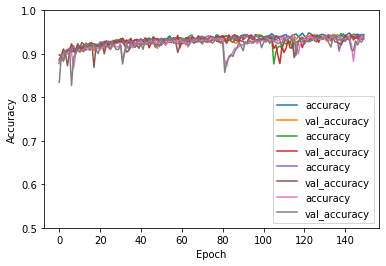

In [8]:
for i in range(len(hs)):
    plt.plot(hs[i].history['accuracy'], label='accuracy')
    plt.plot(hs[i].history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
